<font size="9">JUNO PELT & WALT signals</font><br>
<hr>

In [1]:
import logging
reload(logging)
logging.basicConfig(
    format='%(asctime)-9s %(levelname)-8s: %(message)s',
    datefmt='%I:%M:%S')

# Enable logging at INFO level
logging.getLogger().setLevel(logging.INFO)

In [2]:
# Generate plots inline
%pylab inline

import json
import os
import pandas as pd

# Support for performance analysis of RTApp workloads
from trace_analysis import TraceAnalysis

# Support for trace events analysis
from trace import Trace
from perf_analysis import PerfAnalysis

# Suport for FTrace events parsing and visualization
import trappy

Populating the interactive namespace from numpy and matplotlib


# Test setup

In [3]:
with open(os.path.join('./', 'juno_r2.json'), 'r') as fh:
    platform = json.load(fh)
#print json.dumps(platform, indent=4)
logging.info('LITTLE cluster max capacity: %d',
             platform['nrg_model']['little']['cpu']['cap_max'])

03:12:30  INFO    : LITTLE cluster max capacity: 593


# Configuration

In [4]:
workload='bbench_with_audio'
spec_id='mp_option_walt'
workload_id='w01'
run='1'
#/home/chrred01/work/juno/eas_walt_juno/wlauto_compare/walt_trace_all/t-rex_2.7.0_HD_off_mp_option_walt_b14_1

test_dir = '../../../eas_walt_juno/wlauto_compare/walt_trace_all/{}_{}_{}'.format(workload, spec_id, workload_id)
run_dir = '{}_{}/'.format(test_dir, run)
#platform_json = '{}/platform.json'.format(test_dir)
platform_json = './juno_r2.json'
trace_file = '{}/trace.dat'.format(run_dir)

# Load platform description data
with open(platform_json, 'r') as fh:
    platform = json.load(fh)

# Load Trace data
events = [
    'sched_load_avg_task',
    'sched_load_avg_cpu',
    'sched_switch',
    'sched_overutilized',
    'sched_energy_diff',
    'cpu_frequency'
]
trace = Trace(platform, run_dir, events)


03:12:32  INFO    : Parsing FTrace format...
03:13:03  INFO    : Collected events spans a 147.278 [s] time interval
03:13:03  INFO    : Overutilized time: 17.555490 [s] (11.920% of trace time)


Maximum estimated system energy: 1734


In [5]:
ta = TraceAnalysis(trace, platform)
#ta.plotTasks(['Thread-134'], ['load_avg', 'util_avg', 'sched_overutilized'])


03:13:03  INFO    : Set plots time range to (0.000000, 147.278141)[s]


In [6]:
tasks_by_name = {}
tasks_by_pid = {}

df =  trace.df('sched_switch')
#print df[['next_comm', 'next_pid']]
for time, next_comm, _next_pid in df[['next_comm', 'next_pid']].itertuples():
    next_pid = int(_next_pid)
    # by name first
    if next_comm in tasks_by_name:
        # already in there, make sure the PID is in there too, or add another
        if next_pid not in tasks_by_name[next_comm]:
            tasks_by_name[next_comm].append(next_pid)
    else:
        # not already in there, add this pid
        tasks_by_name[next_comm] = [next_pid,]
    # now same by PID
    if next_pid in tasks_by_pid:
        if next_comm not in tasks_by_pid[next_pid]:
            tasks_by_pid[next_pid].append(next_comm)
    else:
        tasks_by_pid[next_pid] = [next_comm,]
    
print tasks_by_name
print tasks_by_pid


{'busybox': [1496, 1501], 'Thread-128': [1584], 'ndroid.systemui': [554], 'adbd': [166, 1153, 1493, 1154, 1498, 1503, 1506, 1514, 1513, 1518, 1522, 1525, 1601, 1618, 1619, 1622, 1623, 1626, 1627, 1630, 1631, 1634, 1635, 1638, 1639, 1641, 1642], 'netd': [135, 1611, 423, 420, 1616, 1617], 'DispSync': [216], 'Thread-124': [1580], 'lmkd': [119], 'BrowserBlocking': [1583], 'm.android.music': [1377], 'AudioOut_2': [252], 'Chrome_ChildIOT': [1588], 'NPDecoder-CL': [1405], 'Binder_1': [254, 470, 1533, 736, 1113, 565, 215, 1388, 1549, 1548, 738, 732, 602], 'Binder_3': [752, 619, 493, 710, 1053, 1054, 1287], 'Binder_2': [471, 751, 1389, 603, 1534, 217, 1549, 744, 739], 'Binder_5': [746], 'Binder_4': [745, 1270], 'Binder_7': [881], 'Binder_6': [880], 'servicemanager': [120], 'Binder_8': [1284], 'swapper/4': [0], 'main': [1527, 144, 1537, 1539], 'swapper/2': [0], 'swapper/3': [0], 'swapper/0': [0], 'swapper/1': [0], 'ndroid.launcher': [705], 'kworker/1:1H': [163], 'GpuThread': [1596], 'Thread-132'

03:57:37  INFO    : Set plots time range to (0.000000, 147.278141)[s]
03:57:37  INFO    :   task      kworker/0:0 found, pid: [4]
03:57:37  INFO    : 474 593 818 1023


IOError: [Errno 2] No such file or directory: '../../../eas_walt_juno/wlauto_compare/walt_trace_all/bbench_with_audio_mp_option_walt_w01_1//task_util_kworker/0:0.png'

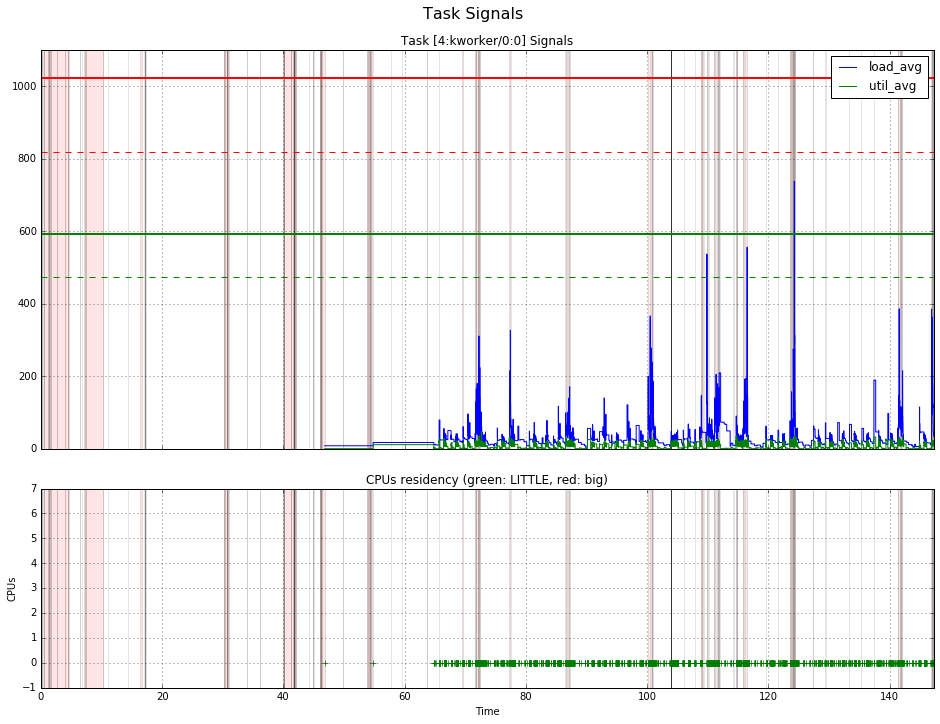

In [16]:
from IPython.display import display
import ipywidgets as widgets
from IPython.display import clear_output

# only want to see PIDs where there is a significant difference between WALT and PELT signal
walt_diff_target = 10000
task_list = []
df = trace.df('sched_load_avg_task').copy()
for pid in sorted(tasks_by_pid):
    pid_df = df[df['pid']==pid]
    if pid_df.empty:
        continue
#    walt_max = pid_df.load_avg.max()
#    if walt_max < 700:
#        continue
    walt_diff = abs(pid_df.util_avg.sum() - pid_df.load_avg.sum())
    if walt_diff < walt_diff_target:
        continue
    task_list.append('{:05d},{}'.format(pid,tasks_by_pid[pid][0]))

xmin=widgets.Text('-1', description='Xmin: (-1 to disable)')
xmax=widgets.Text('-1', description='Xmax: (-1 to disable)')

w = widgets.Dropdown(
    options=task_list,
    description='Tasks'
)
def show_report():
    global w, xmin, xmax
    clear_output()
    pid,taskname = w.value.split(',')
    _xmin=None
    _xmax=None
    if float(xmin.value) >= 0:
        _xmin = float(xmin.value)
    if float(xmax.value) >= 0:
        _xmax = float(xmax.value)
    ta.setXTimeRange(_xmin, _xmax)
    ta.plotTasks([taskname,], ['load_avg', 'util_avg', 'util_est', 'sched_overutilized', 'residencies'])
    ta.plotCPU()
def clicked(b):
    show_report()
def reset(b):
    global xmin,xmax
    xmin.value=-1
    xmax.value=-1
    show_report()
    
w.on_trait_change(show_report, 'value')
button1=widgets.Button(description='Reset')
button1.on_click(reset)
button=widgets.Button(description='Redraw')
button.on_click(clicked)
display(xmin)
display(xmax)
display(button1)
display(button)
display(w)


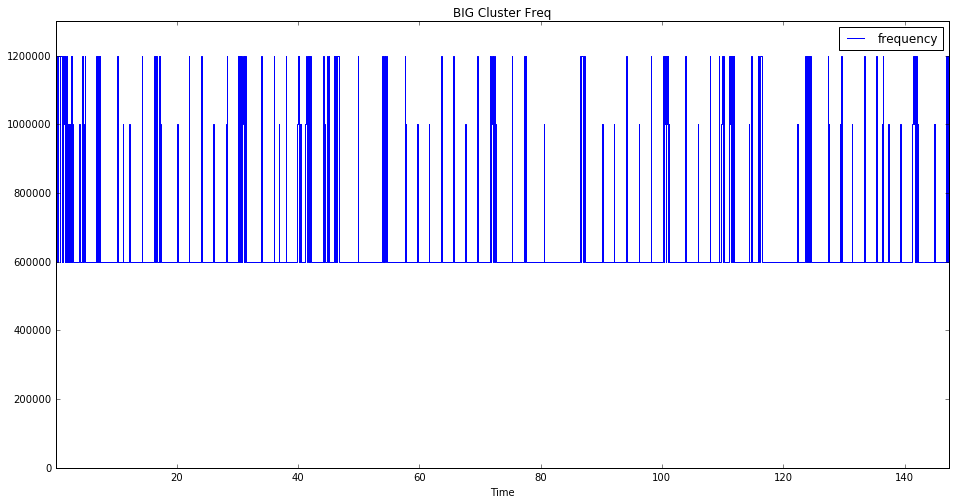

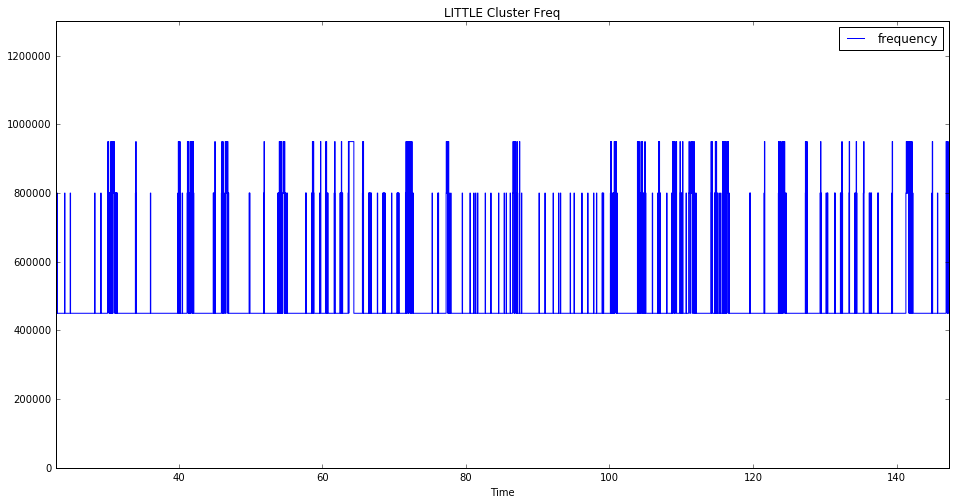

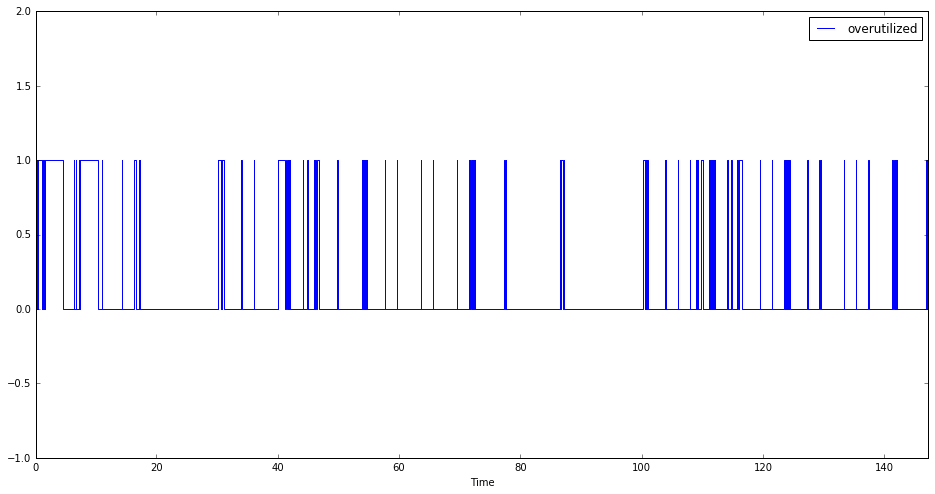

In [10]:
df = trace.df('cpu_frequency').copy()
df_big = df[df['cpu']==1]
df_little = df[df['cpu']==0]
df_big[['frequency']].plot(ylim=(0,1300000),title='BIG Cluster Freq',drawstyle='steps-post',figsize=(16,8))
df_little[['frequency']].plot(ylim=(0,1300000),title='LITTLE Cluster Freq',drawstyle='steps-post',figsize=(16,8))
df = trace.df('sched_overutilized').copy()
df[['overutilized']].plot(drawstyle='steps-post', figsize=(16,8), ylim=(-1,2))

In [ ]:
interesting_pids=None
walt_diff_target=0
pid_list={}
pids_in_trace=tasks_by_pid.keys()

df = trace.df('sched_load_avg_task').copy()
if 'walt_demand' not in df.columns:
    df.rename(columns = {'load_avg':'walt_demand'}, inplace = True)

# PID list filtering:
#   if you want to limit the list of PIDs, put them in 'interesting_pids'
#interesting_pids=[ 1535, 1591, 415, 1589, 1596, 1587 ]
#   if you want to ignore tasks with little difference, set a limit here
walt_diff_target = 10000
for pid in pids_in_trace:
    if interesting_pids and not pid in interesting_pids:
        print 'Skipping {} as not one of our \'interesting\' PIDs'.format(pid)
        continue
    pid_df = df[df['pid']==pid]
    if pid_df.empty:
        print '{} empty'.format(pid)
        continue
    walt_diff = abs(pid_df.util_avg.sum() - pid_df.walt_demand.sum())
    if walt_diff < walt_diff_target:
        print 'Skipping {} as difference between walt and pelt is only {}'.format(pid, walt_diff)
        continue
    pid_list[pid] = walt_diff

for pid in sort(pid_list.keys()):
    pid_df = df[df['pid']==pid]
    pid_title='PID {} ({}). Walt_diff={}'.format(pid, trace.getTaskByPid(pid), pid_list[pid])
    pid_df[['util_avg', 'walt_demand', 'util_est']].plot(drawstyle='steps-post', title=pid_title, ylim=(0,1100), figsize=(16,8))



In [ ]:
# just one plot for a given pid
pid=1589
start=77
end=78


pid_df = df[df['pid']==pid].copy()
# add frequencies & overutilised
df_little_freqs = df_little[['frequency']].apply(lambda x: (platform['nrg_model']['little']['cpu']['cap_max']*x)/max(platform['freqs']['little'])).rename(columns={'frequency':'littleFreq'})
df_big_freqs = df_big[['frequency']].apply(lambda x: (platform['nrg_model']['big']['cpu']['cap_max']*x)/max(platform['freqs']['big'])).rename(columns={'frequency':'bigFreq'})
pid_title='PID {} ({}). Walt_diff={}'.format(pid, trace.getTaskByPid(pid), pid_list[pid])
#pid_df[['util_avg', 'walt_demand', 'util_est', 'littleFreq']].plot(drawstyle='steps-post', title=pid_title, figsize=(16,8))
#df_big_freqs.plot(drawstyle='steps-post', title=pid_title, figsize=(16,8), ylim=(0,1100))
tmp_df=pd.concat([pid_df, df_little_freqs, df_big_freqs])
#tmp_df.plot(drawstyle='steps-post', title=pid_title, figsize=(16,8), ylim=(0,1100))
tmp_df[['util_avg', 'walt_demand', 'util_est']].plot(drawstyle='steps-post', title=pid_title, figsize=(16,8), xlim=(start,end))
tmp_df[['littleFreq', 'bigFreq']].plot(drawstyle='steps-post', title=pid_title, figsize=(16,8), xlim=(start,end))



In [ ]:
df = trace.df('sched_load_avg_cpu').copy()
#if 'walt_demand' not in df.columns:
#    df.rename(columns = {'load_avg':'walt_demand'}, inplace = True)

#for pid in pids_in_trace:
#    pid_df = df[df['pid']==pid].copy()
#    if pid_df.empty:
#        continue
#    if pid_df.util_avg.sum() < 500000:
#        continue
for cpu in range(0,5):
    cpu_df = df[df['cpu']==cpu].copy()
    pid_title='Examining CPU {}'.format(cpu)
    #cpu_df[['util_avg', 'util_est']].plot(drawstyle='steps-post', title=pid_title, ylim=(0,1100), figsize=(16,8), xlim=(43.05,43.10))
    cpu_df[['util_avg', 'util_est']].plot(drawstyle='steps-post', title=pid_title, ylim=(0,1100), figsize=(16,8))
